In [58]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import json
import time
import itertools as it
import sys
sys.path.append('lib')
from analysis_utils import *

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Todo 
- make PR_type a string for all versions

In [152]:
def combine(*vs):
    def loop():
        first_pid = 0
        for v in vs:
            df = pd.read_csv('data/human/0.{}/mouselab-mdp.csv'.format(v))
            pdf = pd.read_csv('data/human/0.{}/participants.csv'.format(v))
            df.pid += first_pid
            pdf.pid += first_pid
            first_pid += max(pdf.pid.max(), df.pid.max()) + 1
            yield df, pdf
    dfs, pdfs = zip(*loop())
    df = pd.concat(dfs).reset_index()
    pdf = pd.concat(pdfs).reset_index().set_index('pid', drop=False)
    return df, pdf

df, pdf = combine(6)

completed = list(pdf.query('completed').pid)
df = df.query('pid == @completed')
pdf = pdf.query('pid == @completed')

df.trial_index = df.trial_index.astype(int)
df.trial_i = df.trial_i.astype(int)
df['version'] = list(pdf.version.loc[df.pid])
df['info_cost'] = list(pdf.info_cost.loc[df.pid])
df['PR_type'] = list(pdf.PR_type.loc[df.pid])
df['message'] = list(pdf.message.loc[df.pid])


from toolz.curried import *
from ast import literal_eval
df.queries = df.queries.apply(literal_eval)
df['clicks'] = df.queries.apply(
    lambda x: lmap(int, x['click']['state']['target'])
)
df['click_times'] = df.queries.apply(
    lambda x: x['click']['state']['time']
)
df.action_times = df.action_times.apply(literal_eval)
df['n_click'] = df.clicks.apply(len)
df.delays = df.delays.apply(literal_eval)
df.path = df.path.apply(
    lambda x: [1] + literal_eval(x)[1:])

pdf['time'] = df.groupby('pid').time_elapsed.max() / 60000
pdf.score = df.groupby('pid').score.sum()

In [153]:
# identifiers = pd.read_csv('data/human_raw/0.6/identifiers.csv')
# pdf = pdf.join(identifiers.set_index('pid'))
# sys.path.append('bin')
# from compensation import Compensator
# comp = Compensator()
# for i, row in pdf.iterrows():
#     comp.approve(row.assignment_id)
#     if row.bonus > 0:
#         comp.grant_bonus(row.worker_id, row.assignment_id, round(row.bonus, 2))

In [154]:
df.action_times[0]

[33292, 51350, 52408]

In [155]:
# def before_first(row):
#     try:
#         a1 = row.action_times[0]
#         return sum(1 for ct in row.click_times if ct < a1)
#     except:
#         return None

# df['early_click'] = df.apply(before_first, axis=1).astype(int)

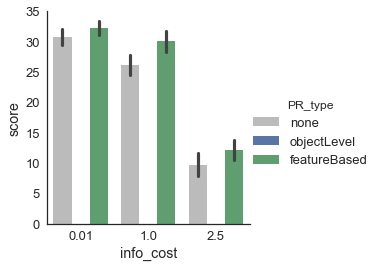

In [156]:
PALETTE = ['#bbbbbb'] + sns.palettes.SEABORN_PALETTES['deep']
sns.set_palette(PALETTE)
PR_ORDER = 'none objectLevel featureBased'.split()
# PR_ORDER = ['objectLevel', 'featureBased']

sns.factorplot('info_cost', 'score', hue='PR_type', data=df, 
               kind='bar', hue_order=PR_ORDER)

In [157]:
INFO_COSTS = [0.01, 1.00, 2.50]
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()].as_matrix()

df['optimal'] = comparison('optimal')
df['worst'] = comparison('worst')

# df['optimal'] = list(optimal.loc[df.trial_i])
df['regret'] = df.score - df.optimal
df['trial_mean'] = list(df.groupby('trial_i').score.mean().loc[df.trial_i])
df['centered_score'] = df.score - df.trial_mean

# (R-R_min)/(R_max-R_min)
df['relative_score'] = (df.score - df.worst) / (df.optimal - df.worst)

In [159]:
cols = ('pid info_cost PR_type message trial_index trial_i '
        'score relative_score n_click clicks click_times path action_times'
        .split())
df[cols].to_csv('data/human/0.6/trials.csv')
df[cols]

,pid,info_cost,PR_type,message,trial_index,trial_i,score,relative_score,n_click,clicks,click_times,path,action_times
0,0,1.00,none,none,1,11,-2.00,-0.183673,9,"[2, 6, 11, 5, 9, 16, 3, 7, 12]","[2650, 7777, 9897, 16490, 18103, 19414, 23097,...","[1, 4, 8, 15]","[33292, 51350, 52408]"
1,0,1.00,none,none,2,0,17.00,0.274510,4,"[3, 7, 13, 12]","[2630, 12133, 16265, 17877]","[1, 3, 7, 13]","[4830, 13917, 32223]"
2,0,1.00,none,none,3,1,34.00,0.882353,10,"[5, 4, 2, 3, 9, 16, 17, 7, 13, 12]","[1885, 2787, 4346, 5245, 8074, 10380, 11296, 1...","[1, 3, 7, 12]","[18668, 27044, 28539]"
3,0,1.00,none,none,4,7,24.00,0.450000,10,"[5, 2, 4, 3, 7, 6, 13, 12, 10, 11]","[1510, 2169, 3135, 3796, 5134, 6219, 7237, 817...","[1, 3, 7, 12]","[11983, 20366, 22805]"
4,0,1.00,none,none,5,3,2.00,0.260870,8,"[5, 4, 3, 2, 7, 8, 14, 15]","[5135, 5858, 6443, 6985, 8221, 9931, 11619, 12...","[1, 4, 8, 15]","[15830, 23838, 25613]"
5,0,1.00,none,none,6,5,29.00,0.836735,8,"[4, 3, 2, 5, 8, 6, 10, 11]","[1706, 3015, 3857, 4506, 5515, 6533, 7631, 8315]","[1, 2, 6, 10]","[11241, 20834, 23682]"
6,0,1.00,none,none,7,9,29.00,0.700000,12,"[5, 4, 3, 2, 9, 16, 8, 14, 15, 7, 12, 13]","[3549, 5420, 7037, 8086, 9012, 9759, 11004, 11...","[1, 4, 8, 15]","[22136, 32087, 33944]"
7,0,1.00,none,none,8,10,30.00,0.729730,10,"[3, 4, 5, 2, 8, 7, 12, 13, 14, 15]","[3255, 4386, 5345, 5939, 7119, 8473, 9313, 102...","[1, 3, 7, 12]","[20412, 44909, 46660]"
8,0,1.00,none,none,9,4,33.00,0.763158,9,"[4, 5, 2, 3, 8, 9, 7, 16, 17]","[1143, 1954, 2646, 3286, 4253, 4975, 5855, 728...","[1, 5, 9, 17]","[26503, 37438, 39004]"
9,0,1.00,none,none,10,8,39.00,0.750000,11,"[5, 4, 3, 2, 9, 8, 7, 15, 14, 16, 17]","[2792, 3394, 3916, 4598, 5799, 6500, 7300, 829...","[1, 4, 8, 15]","[17665, 26705, 29776]"


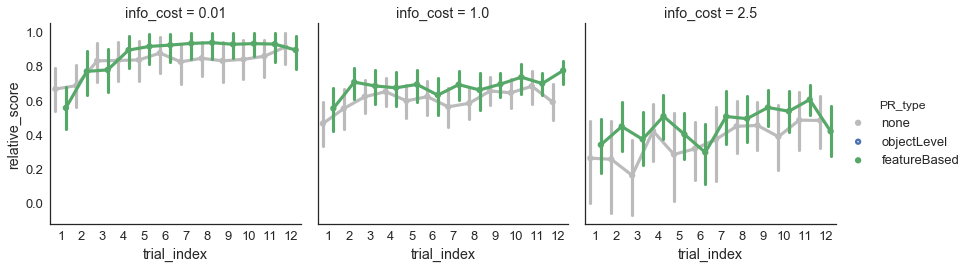

In [130]:
sns.factorplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4,
               dodge=.5, markers='.', ci=95, estimator=np.mean,
               hue_order=PR_ORDER, palette=PALETTE)

In [131]:
rdf = df2r(df, 
           ['info_cost', 'trial_index', 'score', 'n_click', 'pid', 'trial_i', 'PR_type'])

In [243]:
%%R -i rdf
require(lme4)
require(car)
# rdf$info_cost = as.factor(rdf$info_cost)
Anova(lmer('score ~ trial_index * PR_type + (1|pid) + (1|trial_i)', 
           data=rdf
           # data=subset(rdf, info_cost == 2.80)
                      ))


Error in eval(expr, envir, enclos) : object 'PR_type' not found


/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'PR_type' not found

  warnings.warn(x, RRuntimeWarning)


In [238]:
%%R -i rdf
summary(lm('score ~ info_cost * trial_index * PR_type', 
           data=subset(rdf, info_cost > 0)
                      ))


Error in eval(expr, envir, enclos) : object 'PR_type' not found


In [382]:
# from pymc3 import *

# with Model():
#     glm.GLM.from_formula('score ~ PR_type * trial_index', data=df)
#     start = find_MAP()
#     step = NUTS(scaling=start)
#     trace = sample(2000, step)
    

# full = t['PR_type[T.fullObservation]']
# none = t['PR_type[T.none]']
# (none > 0).mean()

Optimization terminated successfully.
         Current function value: 2314.381831

/usr/local/lib/miniconda3/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
  4%|▍         | 82/2000 [00:00<00:11, 173.13it/s]


         Iterations: 47
         Function evaluations: 55
         Gradient evaluations: 55
